# Data Generators

In [1]:
from glob import glob
import os
import matplotlib.pyplot as plt
import cv2
from time import time

import tensorflow as tf
# tf.enable_eager_execution()
tf.VERSION

'1.13.1'

### Get data: train/val paths/labels

('Train data : ', 40000, 40000, 9, 0)
(['../data/cifar10/26447_9.jpg', '../data/cifar10/44664_7.jpg', '../data/cifar10/6752_7.jpg'], [9, 7, 7])


('Validation data : ', 10000, 10000, 9, 0)
(['../data/cifar10/32625_5.jpg', '../data/cifar10/40474_9.jpg', '../data/cifar10/4603_9.jpg'], [5, 9, 9])


(32, 32, 3)


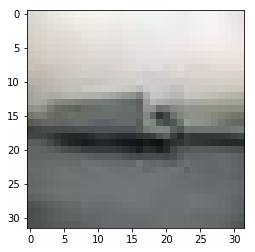

In [2]:
import numpy as np

src_dir = '../data/cifar10/'
img_paths = glob(src_dir + '*.jpg')
N = len(img_paths)

idx = np.arange(N)
np.random.shuffle(idx)
num_train = int(0.8*N)
train_paths = [img_paths[idx[i]] for i in range(num_train)]
val_paths = [img_paths[idx[num_train + i]] for i in range(N - num_train)]

train_labels = []
for path in train_paths:
    name = os.path.basename(path)
    train_labels.append(int(name[name.find('_')+1:-4]))
print('Train data : ', len(train_paths), len(train_labels), max(train_labels), min(train_labels))
print(train_paths[:3], train_labels[:3])
print('\n')


val_labels = []
for path in val_paths:
    name = os.path.basename(path)
    val_labels.append(int(name[name.find('_')+1:-4]))
print('Validation data : ', len(val_paths), len(val_labels), max(val_labels), min(val_labels))
print(val_paths[:3], val_labels[:3])
print('\n')

# Display an image
img = cv2.imread(val_paths[1])
print(img.shape)
plt.imshow(img)
plt.show()

### DataGenerator: Batches of random patches from images and labels

('Val patches = ', [Dimension(64), Dimension(4), Dimension(4), Dimension(3)])
((4, 4, 4, 3), (4,))
Total number of patches = 640, time = 0.628890991211


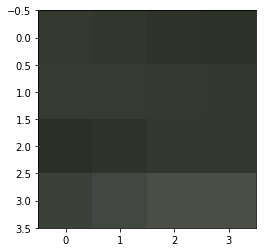

In [65]:
# Training pipeline including datagen, preprocessing and data aug

import numpy as np
from time import time

# Preprocess data
def parse_fn(path, label):
    img = tf.read_file(path)
    img = tf.image.decode_jpeg(img, channels = 3)
#     img = tf.image.convert_image_dtype(img, tf.float32)
    #     if resize == True:
    img = tf.image.resize_images(img, [32, 32])
    img = img/255.0 
    return img, label

# Augment data (translate and rotate)
def augment_fn(img, label):
    img_tx = tf.contrib.image.rotate(img, \
            angles = tf.random_uniform(shape=[], minval=-10, maxval=10))
    img_tx = tf.contrib.image.translate(img_tx, \
            translations = [tf.random_uniform(shape=[], minval=-10, maxval=10), \
                           tf.random_uniform(shape=[], minval=-10, maxval=10)])
    return img_tx, label

def get_train_patches(img, label, num_patches=10, patch_size=4):
    patches = []
    for i in range(num_patches):
        patch = tf.random_crop(img, [patch_size, patch_size, 3])
        patches.append(patch)
    patches = tf.stack(patches)
    assert patches.get_shape().dims == [num_patches, patch_size, patch_size, 3]
    return patches, tf.fill([num_patches], label)

def get_val_patches(img, label, patch_size=4):
    [h, w, ch] = img.shape
    patches = tf.image.extract_image_patches(
                tf.expand_dims(img, 0),
                ksizes = [1, patch_size, patch_size, 1],
                strides = [1, patch_size, patch_size, 1],
                rates = [1, 1, 1, 1],
                padding = 'VALID'
    )    
    num_patches = (h/patch_size) * (w/patch_size)
    patches = tf.reshape(patches, [-1, patch_size, patch_size, ch])
    print('Val patches = ', patches.get_shape().dims)
    return patches, tf.fill([num_patches], label)

batch_size = 4
num_patches = 10
patch_size = 4
# Create train dataset and iterator
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    .shuffle(buffer_size=len(train_paths))
    .map(parse_fn, num_parallel_calls = 4)
    .map(lambda x, y: get_train_patches(x, y, num_patches, patch_size), num_parallel_calls = 4)
    .apply(tf.contrib.data.unbatch())
    .shuffle(buffer_size=10*num_patches)
    .batch(batch_size)
    .prefetch(1)
)
train_iter = train_dataset.make_initializable_iterator()
train_next = train_iter.get_next()

# Create val dataset and iterator
val_dataset = (
    tf.data.Dataset.from_tensor_slices((val_paths[:10], val_labels[:10]))
    .map(parse_fn, num_parallel_calls=4)
    .map(lambda x, y: get_val_patches(x, y, patch_size), num_parallel_calls = 4)
    .apply(tf.contrib.data.unbatch())
    .batch(batch_size)
    .prefetch(0)
)
val_iter = val_dataset.make_initializable_iterator()
val_next = val_iter.get_next()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    sess.run(train_iter.initializer)
    x, y = sess.run(train_next)
    print(x.shape, y.shape)

    sess.run(val_iter.initializer)
    total_patches = 0
    t = time()
    while True:
        try:            
            x, y = sess.run(val_next)
            total_patches += len(y)
        except tf.errors.OutOfRangeError:
            break
assert total_patches == 10*(32/patch_size)**2
print('Total number of patches = {}, time = {}'.\
      format(total_patches, time()-t))
plt.imshow(x[0])
plt.show()

### Getting a grid of patches from an image

In [51]:
n = 10
# images is a 1 x 10 x 10 x 1 array that contains the numbers 1 through 100 in order
images = np.arange(1, 101).reshape(1, 10, 10, 1)
print('Input Image :')
print(images[0, :, :, 0])
print('\n')

# We generate four outputs as follows:
# 1. 3x3 patches with stride length 5
# 2. Same as above, but the rate is increased to 2
# 3. 4x4 patches with stride length 7; only one patch should be generated
# 4. Same as above, but with padding set to 'SAME'
patch_size = 5
patches = tf.extract_image_patches(
            images=images,
            ksizes=[1, patch_size, patch_size, 1], 
            strides=[1, patch_size, patch_size, 1], 
            rates=[1, 1, 1, 1], 
            padding='VALID'
        )
patches = tf.reshape(patches, [-1, 5, 5, 1])
with tf.Session() as sess:
    x = sess.run(patches)
    print('Output Patches = ', x.shape)
    print('\n')
for i in range(4):
    print('Patch ', str(i+1))
    print(x[i, :, :, 0])
    print('\n')

Input Image :
[[  1   2   3   4   5   6   7   8   9  10]
 [ 11  12  13  14  15  16  17  18  19  20]
 [ 21  22  23  24  25  26  27  28  29  30]
 [ 31  32  33  34  35  36  37  38  39  40]
 [ 41  42  43  44  45  46  47  48  49  50]
 [ 51  52  53  54  55  56  57  58  59  60]
 [ 61  62  63  64  65  66  67  68  69  70]
 [ 71  72  73  74  75  76  77  78  79  80]
 [ 81  82  83  84  85  86  87  88  89  90]
 [ 91  92  93  94  95  96  97  98  99 100]]


('Output Patches = ', (4, 5, 5, 1))


('Patch ', '1')
[[ 1  2  3  4  5]
 [11 12 13 14 15]
 [21 22 23 24 25]
 [31 32 33 34 35]
 [41 42 43 44 45]]


('Patch ', '2')
[[ 6  7  8  9 10]
 [16 17 18 19 20]
 [26 27 28 29 30]
 [36 37 38 39 40]
 [46 47 48 49 50]]


('Patch ', '3')
[[51 52 53 54 55]
 [61 62 63 64 65]
 [71 72 73 74 75]
 [81 82 83 84 85]
 [91 92 93 94 95]]


('Patch ', '4')
[[ 56  57  58  59  60]
 [ 66  67  68  69  70]
 [ 76  77  78  79  80]
 [ 86  87  88  89  90]
 [ 96  97  98  99 100]]




### DataGenerator: Batches of images and labels

((32, 224, 224, 3), (32,))
((32, 224, 224, 3), (32,))


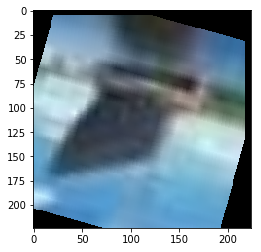

In [6]:
# Preprocess data
def parse_fn(path, label):
    img = tf.read_file(path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize_images(img, [224, 224])
    img = img/255.0
    return img, label

# Augment data (translate and rotate)
def augment_fn(img, label):
    img_tx = tf.contrib.image.rotate(img, \
            angles = tf.random_uniform(shape=[], minval=-10, maxval=10))
    img_tx = tf.contrib.image.translate(img_tx, \
            translations = [tf.random_uniform(shape=[], minval=-10, maxval=10), \
                           tf.random_uniform(shape=[], minval=-10, maxval=10)])
    return img_tx, label

# Train Data
train_data = (
    tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    .shuffle(buffer_size=len(train_paths))
    .map(parse_fn, num_parallel_calls = 4)
    .map(augment_fn, num_parallel_calls = 4)
    .batch(32)
    .prefetch(1)
)
train_iter = train_data.make_initializable_iterator()
train_next = train_iter.get_next()

# Validation data
val_data = (
    tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    .map(parse_fn, num_parallel_calls = 4)
    .batch(32)
    .prefetch(1)
)
val_iter = val_data.make_initializable_iterator()
val_next = val_iter.get_next()

# Verify iterators
num_epochs = 1
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())        
    
    sess.run(train_iter.initializer)
    x_train, y_train = sess.run(train_next)
    print(x_train.shape, y_train.shape)
    
    sess.run(val_iter.initializer)
    x_val, y_val = sess.run(val_iter.get_next())
    print(x_val.shape, y_val.shape)
    
img = x_train[0]
plt.imshow(img)
plt.show()

### DataGenerator: Segmentation Task - image and annotation map (RBG to grayscale converter)

((4, 32, 32, 3), (4, 32, 32, 1))


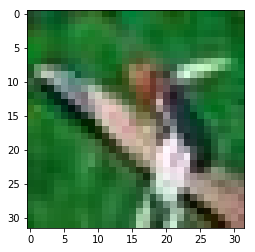

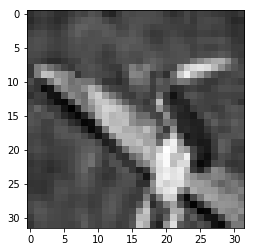

In [8]:
batch_size = 4

def parse_fn(img_path, annot_path):
    img = tf.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [32, 32])
    img = img/255.0
    
    annot = tf.read_file(annot_path)
    annot = tf.image.decode_jpeg(annot, channels=1)
    annot = tf.image.resize(annot, [32, 32])
    annot = annot/255.0
    
    return img, annot

train_annot = train_paths
train_data = (
    tf.data.Dataset.from_tensor_slices((train_paths, train_annot))
    .shuffle(buffer_size = len(train_paths))
    .map(parse_fn, num_parallel_calls = 4)
    .batch(batch_size)
    .prefetch(1)
    )
train_iter = train_data.make_initializable_iterator()
train_next = train_iter.get_next()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(train_iter.initializer)
    x, y = sess.run(train_next)
    print(x.shape, y.shape)

plt.imshow(x[0]); plt.figure()
plt.imshow(y[0, :, :, 0], cmap='gray'); plt.show()